In [1]:
%matplotlib inline

In [2]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import bidding

from batcher import Batcher

In [3]:
seed = 1337

In [4]:
batch_size = 64
n_iterations = 300000
display_step = 10000

In [5]:
A_train = np.load('../data/leads_bin/A_train.npy')
H_train = np.load('../data/leads_bin/H_train.npy')
C_train = np.load('../data/leads_bin/C_train.npy')

A_val = np.load('../data/leads_bin/A_val.npy')
H_val = np.load('../data/leads_bin/H_val.npy')
C_val = np.load('../data/leads_bin/C_val.npy')

In [6]:
A_train.shape, H_train.shape, C_train.shape, A_val.shape, H_val.shape, C_val.shape

((262775, 24, 40),
 (262775, 70),
 (262775, 52),
 (10000, 24, 40),
 (10000, 70),
 (10000, 52))

In [7]:
n_examples = A_train.shape[0]
n_bids = A_train.shape[1]
n_bid_ftrs = A_train.shape[2]
n_hand_ftrs = H_train.shape[1]

In [8]:
n_examples, n_bids, n_bid_ftrs, n_hand_ftrs

(262775, 24, 40, 70)

In [9]:
n_hidden_units = [512, 128]

In [10]:
lstm_size = 32
n_layers = 2

keep_prob = tf.placeholder(tf.float32, name='keep_prob')
l2_reg = 0.04

In [11]:
cells = []
for _ in range(n_layers):
    cell = tf.contrib.rnn.DropoutWrapper(
        tf.nn.rnn_cell.BasicLSTMCell(lstm_size),
        output_keep_prob=keep_prob
    )
    cells.append(cell)

state = []
for i, cell_i in enumerate(cells):
    s_c = tf.placeholder(tf.float32, [1, lstm_size], name='state_c_{}'.format(i))
    s_h = tf.placeholder(tf.float32, [1, lstm_size], name='state_h_{}'.format(i))
    state.append(tf.contrib.rnn.LSTMStateTuple(c=s_c, h=s_h))
state = tuple(state)

lstm_cell = tf.contrib.rnn.MultiRNNCell(cells)

seq_in = tf.placeholder(tf.float32, [None, None, n_bid_ftrs], 'seq_in')

out_rnn, _ = tf.nn.dynamic_rnn(lstm_cell, seq_in, dtype=tf.float32)

In [12]:
out_rnn[:, -1, :].shape

TensorShape([Dimension(None), Dimension(32)])

In [13]:
H = tf.placeholder(tf.float32, shape=[None, n_hand_ftrs], name='H')
C = tf.placeholder(tf.float32, shape=[None, 52], name='H')

In [14]:
fc_in = tf.nn.dropout(
    tf.concat([out_rnn[:, -1, :], H], axis=1, name='fc_in'),
    #H,
    keep_prob,
    seed=seed
)

In [15]:
fc_w = tf.get_variable('fcw', shape=[fc_in.shape.as_list()[1], n_hidden_units[0]], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer(seed=seed))
fc_z = tf.matmul(fc_in, fc_w)
fc_a = tf.nn.relu(fc_z)

fc_w_1 = tf.get_variable('fcw_1', shape=[fc_a.shape.as_list()[1], n_hidden_units[1]], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer(seed=seed))
fc_z_1 = tf.matmul(fc_a, fc_w_1)
fc_a_1 = tf.nn.relu(fc_z_1)

In [16]:
#softmax_w = tf.get_variable('softmax_w', shape=[fc_in.shape.as_list()[1], 52], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer(seed=seed))
#softmax_w = tf.get_variable('softmax_w', shape=[n_hidden_units[0], 52], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer(seed=seed))
softmax_w = tf.get_variable('softmax_w', shape=[n_hidden_units[1], 52], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer(seed=seed))

In [17]:
#pred = tf.matmul(fc_a, softmax_w)
pred = tf.multiply(H[:, 18:], tf.matmul(fc_a_1, softmax_w))
#pred = tf.multiply(H[:, 18:], tf.matmul(fc_in, softmax_w))
#pred = tf.nn.softmax(tf.multiply(H[:, 18:], tf.matmul(fc_a, softmax_w)))
#pred = tf.nn.softmax(tf.matmul(fc_a_1, softmax_w))

In [18]:
#weights = [softmax_w]
#weights = [fc_w, softmax_w]
weights = [fc_w, fc_w_1, softmax_w]

In [19]:
#labels = tf.nn.relu(-1 * (C - 3))
labels = tf.nn.relu(-1 * (C - 1))
#class_labels = tf.nn.relu(-1 * (C - 1))

In [20]:
#cost_pred = tf.reduce_sum(tf.multiply(pred, C))
cost_pred = tf.reduce_sum(tf.squared_difference(pred, labels))
#cost_pred = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=class_labels))
cost_reg = l2_reg * (1.0 / (2*batch_size)) * sum([tf.reduce_sum(tf.square(w)) for w in weights])
cost = cost_pred/batch_size + cost_reg

In [21]:
train_step = tf.train.AdamOptimizer(0.0001).minimize(cost)
#train_step = tf.train.MomentumOptimizer(0.001, momentum=0.9).minimize(cost)

In [22]:
def metric(predictions, costs):
    predicted_indexes = np.argmax(predictions, axis=1)
    result = []
    for i in range(len(predictions)):
        result.append(costs[i, predicted_indexes[i]])
        
    return result

In [23]:
batch = Batcher(n_examples, batch_size)
cost_batch = Batcher(n_examples, 10000)

#with tf.Session() as sess:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

#saver = tf.train.Saver(max_to_keep=20)

#     print(C_val[0:1,:].reshape((4, 13)))

#     labels = tf.nn.relu(-1 * (C - 1))
#     print(sess.run(labels, feed_dict={C: C_val[0:1,:]}).reshape((4, 13)))

for i in range(n_iterations):
    a_batch, h_batch, c_batch = batch.next_batch([A_train, H_train, C_train])
    if i % display_step == 0:
        #print(i)
        a_cost, h_cost, c_cost = cost_batch.next_batch([A_train, H_train, C_train])
        c_train_pred = sess.run(cost_pred, feed_dict={seq_in: a_cost, H: h_cost, C: c_cost, keep_prob: 1.0})
        c_train_reg = sess.run(cost_reg, feed_dict={seq_in: a_cost, H: h_cost, C: c_cost, keep_prob: 1.0})
        #pred_train = sess.run(cost_pred, feed_dict={seq_in: a_cost, H: h_cost, C: c_cost, keep_prob: 1.0})
        c_valid = sess.run(cost_pred, feed_dict={seq_in: A_val, H: H_val, C: C_val, keep_prob: 1.0})
        pred_valid = sess.run(pred, feed_dict={seq_in: A_val, H: H_val, keep_prob: 1.0})
        metric_valid = np.mean(metric(pred_valid, C_val))
        print(i, metric_valid)
        print('{}. c_train_reg={} c_train_pred={} c_valid={}'.format(i, c_train_reg, c_train_pred/10000, c_valid/10000))
        #print(sess.run(pred, feed_dict={seq_in: A_val[0:1,:,:], H: H_val[0:1,:], keep_prob: 1.0}).reshape((4, 13)))
        #print(H_val[0:1,18:].reshape((4, 13)))
        #print(sess.run(labels, feed_dict={C: C_val[0:1,:]}).reshape((4, 13)))
        sys.stdout.flush()

        #saver.save(sess, model_path, global_step=i)
    sess.run(train_step, feed_dict={seq_in: a_batch, H: h_batch, C: c_batch, keep_prob: 0.8})

    #saver.save(sess, model_path, global_step=n_iterations)

0 0.42798
0. c_train_reg=0.14070451259613037 c_train_pred=9.3592171875 c_valid=9.376296875
10000 0.28003
10000. c_train_reg=0.07392648607492447 c_train_pred=2.8180029296875 c_valid=2.830189453125
20000 0.26611
20000. c_train_reg=0.05684427171945572 c_train_pred=2.844240625 c_valid=2.85515078125
30000 0.25269
30000. c_train_reg=0.04921437054872513 c_train_pred=2.87601875 c_valid=2.9079017578125
40000 0.25146
40000. c_train_reg=0.04484087973833084 c_train_pred=2.8759578125 c_valid=2.9102501953125
50000 0.24646
50000. c_train_reg=0.0422501415014267 c_train_pred=2.9044515625 c_valid=2.9496728515625
60000 0.23975
60000. c_train_reg=0.04071850702166557 c_train_pred=2.835347265625 c_valid=2.890914453125
70000 0.23523
70000. c_train_reg=0.03975921869277954 c_train_pred=2.860270703125 c_valid=2.9125181640625
80000 0.23755
80000. c_train_reg=0.039076317101716995 c_train_pred=2.8760310546875 c_valid=2.912582421875
90000 0.24011
90000. c_train_reg=0.038642171770334244 c_train_pred=2.8665607421875 

In [24]:
predictions = sess.run(pred, feed_dict={seq_in: A_val, H: H_val, keep_prob: 1.0})

In [60]:
i = 22
print(predictions[i].reshape((4, 13)))
print(C_val[i].reshape((4, 13)))

[[ 0.          0.62651581  0.60838091  0.          0.36786777  0.          0.
   0.          0.          0.32376695  0.          0.32529593  0.        ]
 [ 0.          0.          0.58753872  0.          0.          0.          0.
   0.          0.          0.5059678   0.          0.          0.        ]
 [ 0.          0.          0.          0.38672662  0.          0.          0.
   0.47679934  0.          0.47485638  0.          0.          0.        ]
 [ 0.49564317  0.          0.31673357  0.          0.          0.          0.
   0.          0.          0.34423825  0.          0.          0.        ]]
[[ 40.   1.   1.  40.   1.  40.  40.  40.  40.   1.  40.   1.  40.]
 [ 40.  40.   0.  40.  40.  40.  40.  40.  40.   0.  40.  40.  40.]
 [ 40.  40.  40.   0.  40.  40.  40.   0.  40.   0.  40.  40.  40.]
 [  0.  40.   0.  40.  40.  40.  40.  40.  40.   1.  40.  40.  40.]]


In [61]:
recovered_auction = [bidding.ID2BID[np.argmax(A_val[i, k, :])] for k in range(24)]
recovered_auction[(24 - list(reversed(recovered_auction)).index('PAD_START')):]

['1S', 'X', '1N', '2D', 'PASS', 'PASS', 'PASS']

In [62]:
metric(predictions[i:i+1, :], C_val[i:i+1, :])

[1.0]

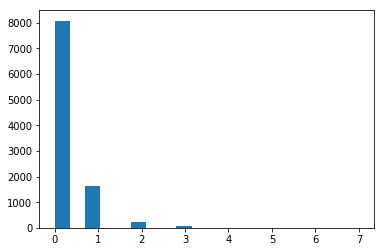

In [34]:
plt.hist(metric(predictions, C_val), 20);

In [36]:
np.mean(metric(predictions, C_val))

0.22925